# FX Options Pricing with Bergomi Local–Stochastic Volatility
This notebook demonstrates how to combine a local volatility surface (Dupire) with a stochastic volatility factor of the Bergomi type to
price FX options.  After importing the necessary functions, we build a local volatility surface from synthetic prices, then
we compare the prices obtained via the Garman–Kohlhagen model, via a pure local volatility model and via a stochastic local model.

You can run the `demo()` function to see the results or use the functions individually for your own parameters.

One‑year ATM call price (GK model): 0.104368
One‑year ATM call price (Local vol MC): 0.143156
One‑year ATM call price (Bergomi LSV MC): 0.125732



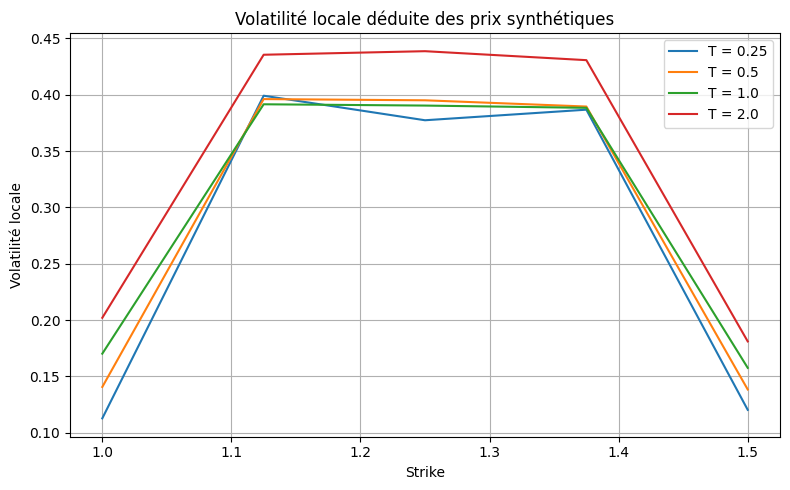

In [1]:
"""
Pricing FX options under a Bergomi-style local–stochastic volatility model
=======================================================================

We implement a simple local–stochastic volatility (LSV) framework
for foreign‑exchange (FX) options.  The goal is to demonstrate how a
Bergomi‑style volatility factor can be combined with a Dupire local
volatility surface to price European FX options.  The code follows the
structure of the Garman–Kohlhagen and local volatility examples but adds
a stochastic variance component inspired by the Bergomi (lognormal
volatility) model.

Key features
------------

* **Garman–Kohlhagen pricing** of vanilla FX options.
* **Dupire local volatility surface** construction from a grid of option prices.
* **Bergomi LSV simulation**: asset dynamics driven by a local volatility
  term multiplied by a lognormal stochastic volatility factor.  The
  stochastic factor follows an Ornstein–Uhlenbeck process for the
  volatility of volatility and is correlated with the asset diffusion.
* **Monte Carlo pricing** under the LSV model.

The example in the ``demo`` function uses synthetic market data based on a
constant volatility to build a local volatility surface.  It then prices
an at‑the‑money call under (i) Garman–Kohlhagen, (ii) pure local
volatility, and (iii) local–stochastic volatility with a Bergomi factor.
The numerical results illustrate how the LSV model modifies the price
relative to the pure LV model.  In practice, one would calibrate the
parameters of the stochastic factor (mean reversion, volatility of
volatility, correlation) to market data.

Note: The implementation here is intentionally pedagogical.  A full
rough‑Bergomi implementation would require generating fractional Brownian
motions; we instead model the volatility factor as an Ornstein–Uhlenbeck
process and exponentiate it to obtain a lognormal volatility term, as in
the classical Bergomi model.  This captures the key idea of coupling
local and stochastic volatility without the heavy machinery of rough
volatility.

Example usage::

    python bergomi_local_vol_fx.py

Running the script will print the prices of a one‑year at‑the‑money call
under the different models and display a plot of the inferred local
volatility surface.

"""

from __future__ import annotations

import numpy as np
from scipy.stats import norm
from scipy.optimize import brentq
from scipy.interpolate import RegularGridInterpolator
import matplotlib.pyplot as plt


def garman_kohlhagen_call(
    S0: float,
    K: float,
    T: float,
    rd: float,
    rf: float,
    sigma: float,
) -> float:
    """Price an FX call option under the Garman–Kohlhagen model.

    Parameters
    ----------
    S0 : float
        Spot exchange rate.
    K : float
        Strike price.
    T : float
        Time to maturity (in years).
    rd : float
        Domestic risk‑free interest rate.
    rf : float
        Foreign risk‑free interest rate.
    sigma : float
        Volatility of the underlying.

    Returns
    -------
    float
        The price of the call option.
    """
    if T <= 0:
        return max(S0 - K, 0.0)
    vol_sqrt_T = sigma * np.sqrt(T)
    d1 = (np.log(S0 / K) + (rd - rf + 0.5 * sigma ** 2) * T) / vol_sqrt_T
    d2 = d1 - vol_sqrt_T
    call = S0 * np.exp(-rf * T) * norm.cdf(d1) - K * np.exp(-rd * T) * norm.cdf(d2)
    return call


def garman_kohlhagen_put(
    S0: float,
    K: float,
    T: float,
    rd: float,
    rf: float,
    sigma: float,
) -> float:
    """Price an FX put option under the Garman–Kohlhagen model using put–call parity."""
    call = garman_kohlhagen_call(S0, K, T, rd, rf, sigma)
    forward = S0 * np.exp((rd - rf) * T)
    put = call + K * np.exp(-rd * T) - forward * np.exp(-rf * T)
    return put


def implied_vol_black(
    price: float,
    S0: float,
    K: float,
    T: float,
    rd: float,
    rf: float,
    option_type: str = "call",
) -> float:
    """Compute the implied volatility under the Garman–Kohlhagen/Black–Scholes model.

    Parameters
    ----------
    price : float
        Observed option price.
    S0 : float
        Spot exchange rate.
    K : float
        Strike price.
    T : float
        Time to maturity.
    rd : float
        Domestic rate.
    rf : float
        Foreign rate.
    option_type : str, optional
        'call' or 'put'.

    Returns
    -------
    float
        Implied volatility.
    """
    if price <= 0 or T <= 0:
        return 0.0

    def objective(sig: float) -> float:
        if option_type == "call":
            return garman_kohlhagen_call(S0, K, T, rd, rf, sig) - price
        else:
            return garman_kohlhagen_put(S0, K, T, rd, rf, sig) - price

    try:
        vol = brentq(objective, 1e-6, 5.0)
    except ValueError:
        vol = np.nan
    return vol


def build_local_vol_surface(
    maturities: np.ndarray,
    strikes: np.ndarray,
    call_prices: np.ndarray,
    rd: float,
    rf: float,
) -> tuple[RegularGridInterpolator, np.ndarray, np.ndarray]:
    """Construct the local volatility surface using the Dupire formula.

    Given a grid of call prices C(T, K), approximate the required derivatives
    and compute the local volatility :math:`\sigma_\text{loc}(T,K)`.

    Parameters
    ----------
    maturities : np.ndarray
        Array of maturities T_i of shape (n_T,).
    strikes : np.ndarray
        Array of strikes K_j of shape (n_K,).
    call_prices : np.ndarray
        2D array of shape (n_T, n_K) containing call prices C(T_i, K_j).
    rd : float
        Domestic rate.
    rf : float
        Foreign rate.

    Returns
    -------
    tuple
        (interpolator, grid_T, grid_K)
        - interpolator : callable accepting t and k and returning local vol.
        - grid_T : 1D array of maturity grid (same as input).
        - grid_K : 1D array of strike grid (same as input).
    """
    nT, nK = call_prices.shape
    local_vol2 = np.zeros_like(call_prices)
    dT = np.diff(maturities)
    dK = np.diff(strikes)

    for i in range(nT):
        for j in range(nK):
            T = maturities[i]
            K = strikes[j]
            C = call_prices[i, j]
            # Time derivative
            if i == 0:
                dC_dT = (call_prices[i + 1, j] - call_prices[i, j]) / dT[i]
            elif i == nT - 1:
                dC_dT = (call_prices[i, j] - call_prices[i - 1, j]) / dT[i - 1]
            else:
                dC_dT = (call_prices[i + 1, j] - call_prices[i - 1, j]) / (maturities[i + 1] - maturities[i - 1])
            # First strike derivative
            if j == 0:
                dC_dK = (call_prices[i, j + 1] - call_prices[i, j]) / dK[0]
            elif j == nK - 1:
                dC_dK = (call_prices[i, j] - call_prices[i, j - 1]) / dK[-1]
            else:
                dC_dK = (call_prices[i, j + 1] - call_prices[i, j - 1]) / (strikes[j + 1] - strikes[j - 1])
            # Second strike derivative
            if j == 0:
                d2C_dK2 = (call_prices[i, j] - 2 * call_prices[i, j + 1] + call_prices[i, j + 2]) / (dK[0] ** 2)
            elif j == nK - 1:
                d2C_dK2 = (call_prices[i, j - 2] - 2 * call_prices[i, j - 1] + call_prices[i, j]) / (dK[-1] ** 2)
            else:
                d2C_dK2 = (
                    call_prices[i, j + 1]
                    - 2 * call_prices[i, j]
                    + call_prices[i, j - 1]
                ) / (strikes[j + 1] - strikes[j - 1]) ** 2
            numerator = dC_dT + (rd - rf) * K * dC_dK + rf * C
            denominator = 0.5 * (K ** 2) * d2C_dK2
            if denominator <= 0 or numerator <= 0:
                local_vol2[i, j] = np.nan
            else:
                local_vol2[i, j] = numerator / denominator
    local_vol = np.sqrt(np.maximum(local_vol2, 1e-12))
    interp = RegularGridInterpolator((maturities, strikes), local_vol, method="linear", bounds_error=False, fill_value=None)
    return interp, maturities, strikes


def local_vol_price_mc(
    S0: float,
    K: float,
    T: float,
    rd: float,
    rf: float,
    local_vol_interp,
    num_paths: int = 10000,
    num_steps: int = 200,
    option_type: str = "call",
) -> float:
    """Price a European option using Monte Carlo under the pure local volatility model.

    Parameters
    ----------
    S0 : float
        Spot price.
    K : float
        Strike.
    T : float
        Maturity.
    rd : float
        Domestic rate.
    rf : float
        Foreign rate.
    local_vol_interp : callable
        Interpolator giving local volatility as a function of (t, S).
    num_paths : int
        Number of Monte Carlo paths.
    num_steps : int
        Number of time steps.
    option_type : str
        'call' or 'put'.

    Returns
    -------
    float
        Discounted expected payoff under risk–neutral measure.
    """
    dt = T / num_steps
    S = np.full(num_paths, S0)
    for i in range(num_steps):
        t = i * dt
        Z = np.random.standard_normal(num_paths)
        pts = np.column_stack((np.full_like(S, t), S))
        sigma = local_vol_interp(pts)
        drift = (rd - rf) * S * dt
        diffusion = sigma * S * np.sqrt(dt) * Z
        S = np.maximum(S + drift + diffusion, 1e-12)
    if option_type == "call":
        payoff = np.maximum(S - K, 0.0)
    else:
        payoff = np.maximum(K - S, 0.0)
    price = np.exp(-rd * T) * np.mean(payoff)
    return price


def bergomi_lsv_price_mc(
    S0: float,
    K: float,
    T: float,
    rd: float,
    rf: float,
    local_vol_interp,
    nu: float,
    rho: float,
    lam: float = 0.0,
    num_paths: int = 10000,
    num_steps: int = 200,
    option_type: str = "call",
) -> float:
    """Price a European option using Monte Carlo under a Bergomi local–stochastic volatility model.

    The asset follows the SDE

    .. math::

       dS_t = (r_d - r_f) S_t\,dt + \sigma_{\text{loc}}(t,S_t)\,\exp(V_t)\,S_t\,dW_t,\\
       dV_t = -\lambda V_t\,dt + \nu\,dW^v_t,

    where :math:`W_t` and :math:`W^v_t` are Brownian motions with correlation
    :math:`\rho`.  When :math:`\lambda = 0`, :math:`V_t` is a Brownian motion scaled by
    :math:`\nu`.  Exponentiating :math:`V_t` yields a lognormally distributed
    multiplicative factor for the local volatility surface, as in the classical
    Bergomi model.  Setting :math:`\nu` or :math:`\rho` to zero recovers the
    pure local volatility model.

    Parameters
    ----------
    S0 : float
        Spot price.
    K : float
        Strike.
    T : float
        Maturity.
    rd : float
        Domestic rate.
    rf : float
        Foreign rate.
    local_vol_interp : callable
        Interpolator returning \sigma_{loc}(t,S).
    nu : float
        Volatility of the volatility factor.
    rho : float
        Correlation between the asset Brownian motion and the volatility factor.
    lam : float, optional
        Mean reversion rate of the volatility factor.  Defaults to 0 (no mean reversion).
    num_paths : int
        Number of Monte Carlo paths.
    num_steps : int
        Number of time steps.
    option_type : str
        'call' or 'put'.

    Returns
    -------
    float
        Discounted expected payoff under risk–neutral measure.
    """
    dt = T / num_steps
    S = np.full(num_paths, S0)
    V = np.zeros(num_paths)
    # Precompute correlation coefficients for Brownian increments
    sqrt_dt = np.sqrt(dt)
    sqrt_1_minus_rho2 = np.sqrt(1.0 - rho ** 2)
    for i in range(num_steps):
        t = i * dt
        # Generate uncorrelated standard normals
        Z1 = np.random.standard_normal(num_paths)
        Z2 = np.random.standard_normal(num_paths)
        # Correlated Brownian increments
        dW = Z1 * sqrt_dt
        dWv = (rho * Z1 + sqrt_1_minus_rho2 * Z2) * sqrt_dt
        # Update volatility factor (Ornstein–Uhlenbeck)
        V = V + (-lam * V) * dt + nu * dWv
        # Compute local volatility at current time and asset level
        pts = np.column_stack((np.full_like(S, t), S))
        sigma_loc = local_vol_interp(pts)
        sigma = sigma_loc * np.exp(V)
        # Update asset price
        drift = (rd - rf) * S * dt
        diffusion = sigma * S * dW
        S = np.maximum(S + drift + diffusion, 1e-12)
    if option_type == "call":
        payoff = np.maximum(S - K, 0.0)
    else:
        payoff = np.maximum(K - S, 0.0)
    price = np.exp(-rd * T) * np.mean(payoff)
    return price


def demo() -> None:
    """Run a demonstration comparing GK, LV and Bergomi LSV pricing."""
    # Synthetic FX market parameters
    S0 = 1.25  # spot exchange rate (e.g. EUR/USD)
    rd = 0.02  # domestic interest rate (USD)
    rf = 0.01  # foreign interest rate (EUR)
    base_vol = 0.20  # base volatility used for synthetic prices

    # Grid of maturities and moneyness levels
    maturities = np.array([0.25, 0.5, 1.0, 2.0])
    moneyness_levels = np.array([0.8, 0.9, 1.0, 1.1, 1.2])
    strikes = S0 * moneyness_levels

    # Generate synthetic call prices using Garman–Kohlhagen with constant vol
    call_prices = np.zeros((len(maturities), len(strikes)))
    for i, T in enumerate(maturities):
        for j, K in enumerate(strikes):
            call_prices[i, j] = garman_kohlhagen_call(S0, K, T, rd, rf, base_vol)

    # Build local volatility surface
    local_vol_interp, T_grid, K_grid = build_local_vol_surface(maturities, strikes, call_prices, rd, rf)

    # Price a one‑year at‑the‑money call under different models
    K_target = S0
    T_target = 1.0
    price_gk = garman_kohlhagen_call(S0, K_target, T_target, rd, rf, base_vol)
    price_lv = local_vol_price_mc(S0, K_target, T_target, rd, rf, local_vol_interp, num_paths=20000, num_steps=250)
    # Parameters for the Bergomi factor
    nu = 0.3  # volatility of volatility
    rho = -0.5  # correlation between asset and vol factor
    lam = 0.0  # no mean reversion
    price_lsv = bergomi_lsv_price_mc(
        S0,
        K_target,
        T_target,
        rd,
        rf,
        local_vol_interp,
        nu=nu,
        rho=rho,
        lam=lam,
        num_paths=20000,
        num_steps=250,
    )

    print(f"One‑year ATM call price (GK model): {price_gk:.6f}")
    print(f"One‑year ATM call price (Local vol MC): {price_lv:.6f}")
    print(f"One‑year ATM call price (Bergomi LSV MC): {price_lsv:.6f}\n")

    # Plot local volatility surface at the discrete maturities
    plt.figure(figsize=(8, 5))
    for T in maturities:
        lv_row = [local_vol_interp(np.array([[T, k]])).item() for k in strikes]
        plt.plot(strikes, lv_row, label=f"T = {T}")
    plt.title("Volatilité locale déduite des prix synthétiques")
    plt.xlabel("Strike")
    plt.ylabel("Volatilité locale")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    demo()